## Loading training data

In [30]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [31]:
data = pd.read_parquet("train-00000-of-00001-c08a401c53fe5312.parquet") 
data.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


## Data pre-processing

In [33]:
def bytes_to_image(d):
    if isinstance(d, dict) and "bytes" in d:
        bytes_ls = d["bytes"]
        np_ls = np.frombuffer(bytes_ls, np.uint8)
        image = cv2.imdecode(np_ls, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128, 128))
        return image
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(d)}")

In [34]:
data["img_arr"] = data["image"].apply(bytes_to_image)
data.drop("image", axis = 1, inplace = True)
data.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [35]:
X = np.stack(data["img_arr"])
X = X.reshape(-1, 128, 128, 1).astype("float32") / 255.0
y_labels = data["label"].astype("category").cat.codes
y = to_categorical(y_labels, num_classes=len(np.unique(y_labels)))

## Decision tree classifier


Fold 1:
Accuracy: 0.697


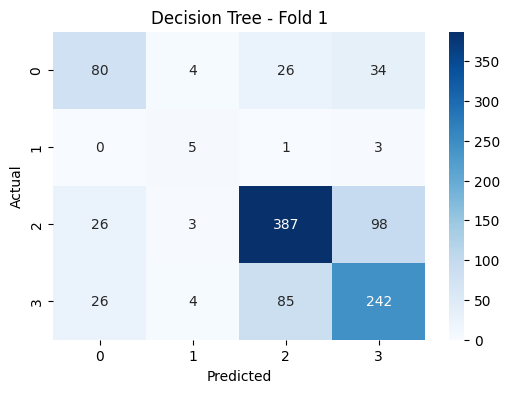


Fold 2:
Accuracy: 0.701


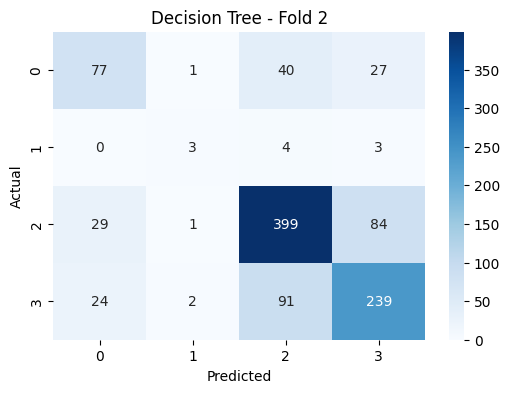


Fold 3:
Accuracy: 0.697


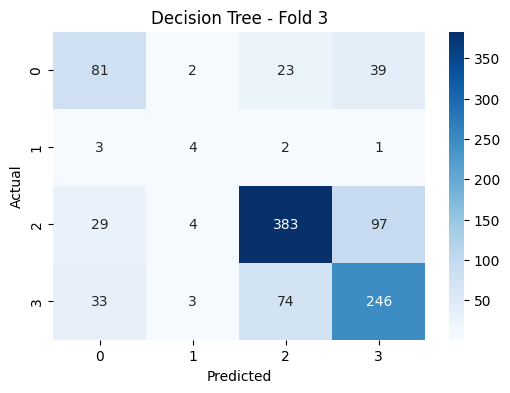


Fold 4:
Accuracy: 0.700


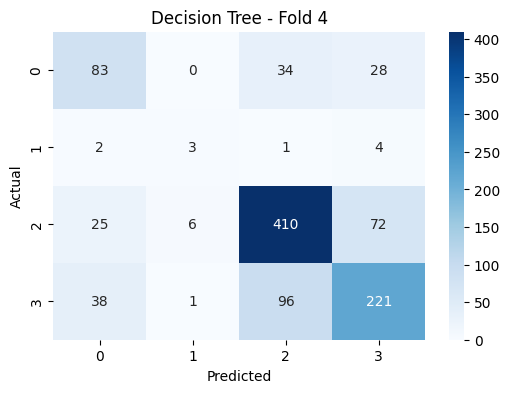


Fold 5:
Accuracy: 0.682


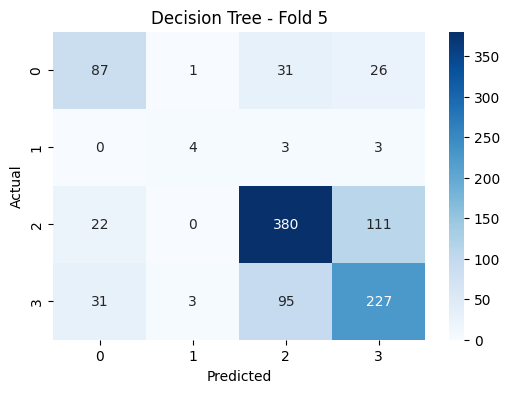


Average Accuracy with k-fold cross-validation (Decision tree classifier): 0.696


In [37]:
from sklearn.tree import DecisionTreeClassifier

kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
fold_no = 1
decision_tree_fold_accuracies = []

for train_idx, val_idx in kf.split(X, y_labels):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_labels[train_idx], y_labels[val_idx]

    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

    decision_tree_clf = DecisionTreeClassifier(random_state = 42)
    decision_tree_clf.fit(X_train_flat, y_train)
    
    y_pred = decision_tree_clf.predict(X_val_flat)
    accuracy = accuracy_score(y_val, y_pred)
    decision_tree_fold_accuracies.append(accuracy)

    print(f"\nFold {fold_no}:")
    print(f"Accuracy: {accuracy:.3f}")

    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize = (6, 4))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues")
    plt.title(f"Decision Tree - Fold {fold_no}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fold_no += 1

print("\nAverage Accuracy with k-fold cross-validation (Decision tree classifier): {:.3f}".format(np.mean(decision_tree_fold_accuracies)))

## Bagging classifier


Fold 1:
Accuracy: 0.856


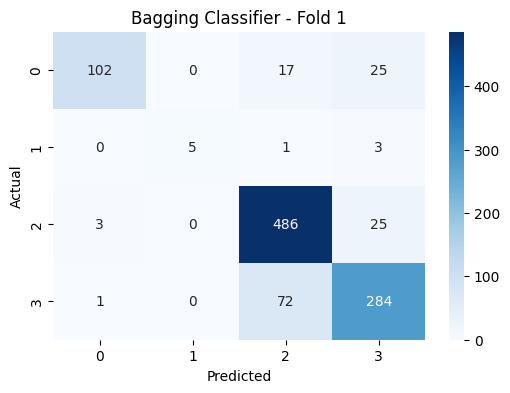


Fold 2:
Accuracy: 0.883


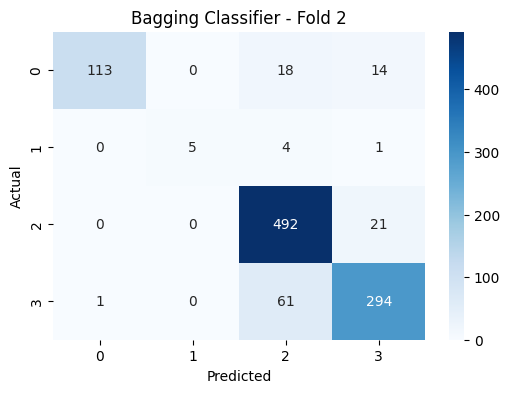


Fold 3:
Accuracy: 0.867


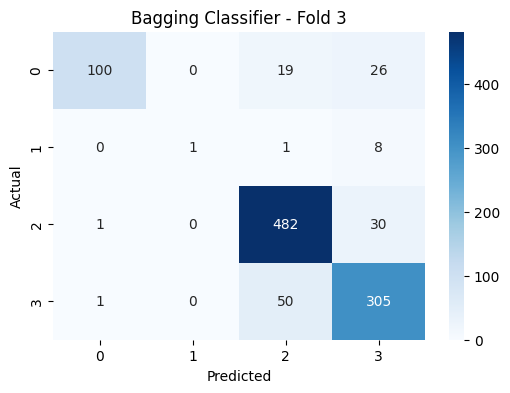


Fold 4:
Accuracy: 0.863


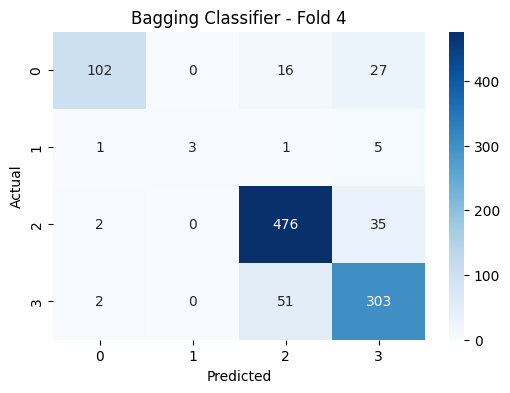


Fold 5:
Accuracy: 0.868


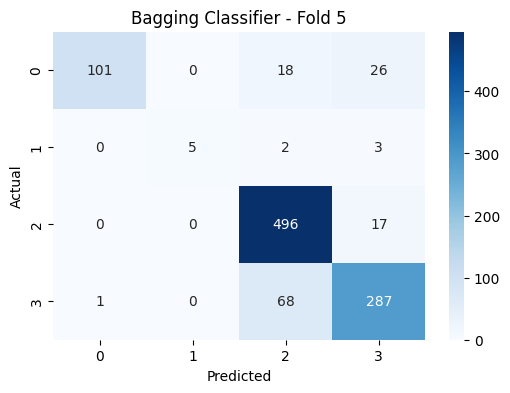


Average Accuracy with k-fold cross-validation (Bagging classifier): 0.868


In [39]:
from sklearn.ensemble import BaggingClassifier

fold_no = 1
bagging_fold_accuracies = []

for train_idx, val_idx in kf.split(X, y_labels):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_labels[train_idx], y_labels[val_idx]

    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

    bagging_clf = BaggingClassifier(estimator = DecisionTreeClassifier(random_state = 42), n_estimators = 25, random_state = 42)
    bagging_clf.fit(X_train_flat, y_train)
    
    y_pred = bagging_clf.predict(X_val_flat)
    accuracy = accuracy_score(y_val, y_pred)
    bagging_fold_accuracies.append(accuracy)

    print(f"\nFold {fold_no}:")
    print(f"Accuracy: {accuracy:.3f}")

    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize = (6, 4))
    sns.heatmap(cm, annot=True, fmt = "d", cmap = "Blues")
    plt.title(f"Bagging Classifier - Fold {fold_no}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fold_no += 1

print("\nAverage Accuracy with k-fold cross-validation (Bagging classifier): {:.3f}".format(np.mean(bagging_fold_accuracies)))

## Random forest classifier

Selected model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Fold 1:
Accuracy: 0.881


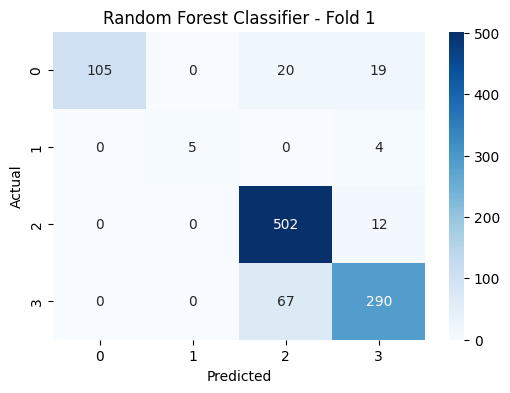

Selected model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Fold 2:
Accuracy: 0.906


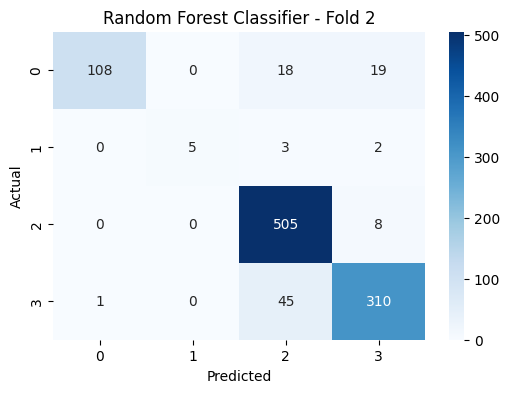

Selected model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Fold 3:
Accuracy: 0.867


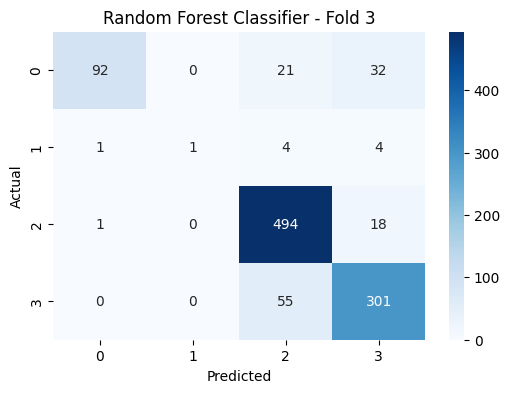

Selected model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Fold 4:
Accuracy: 0.891


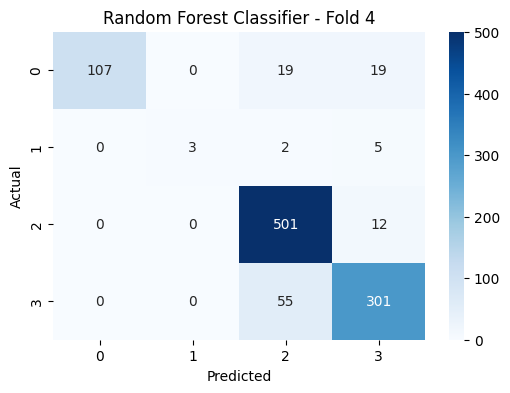

Selected model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Fold 5:
Accuracy: 0.887


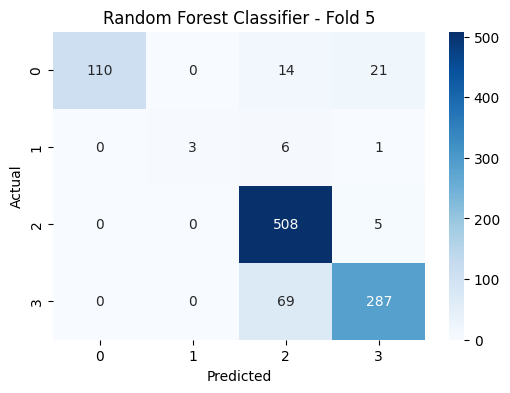


Average Accuracy with k-fold cross-validation (Random forest classifier): 0.886


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def grid_search_for_classifier(clf, param_grid, X_train, y_train):
    grid_search = GridSearchCV(clf, param_gri = param_grid, scoring = "accuracy", cv = 5)
    grid_search.fit(X_train, y_train)
    clf.set_params(**grid_search.best_params_)
    return clf

param_grid = {
    "n_estimators": [10, 50, 100],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"],
    "random_state": [42]
}

fold_no = 1
random_forest_fold_accuracies = []

for train_idx, val_idx in kf.split(X, y_labels):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_labels[train_idx], y_labels[val_idx]

    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

    random_forest_clf = RandomForestClassifier()
    random_forest_clf = grid_search_for_classifier(random_forest_clf, param_grid, X_train_flat, y_train)
    random_forest_clf.fit(X_train_flat, y_train)

    best_params = random_forest_clf.get_params()
    print(f"Selected model parameters: {best_params}")
    
    y_pred = random_forest_clf.predict(X_val_flat)
    accuracy = accuracy_score(y_val, y_pred)
    random_forest_fold_accuracies.append(accuracy)

    print(f"\nFold {fold_no}:")
    print(f"Accuracy: {accuracy:.3f}")

    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize = (6, 4))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues")
    plt.title(f"Random Forest Classifier - Fold {fold_no}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fold_no += 1

print("\nAverage Accuracy with k-fold cross-validation (Random forest classifier): {:.3f}".format(np.mean(random_forest_fold_accuracies)))

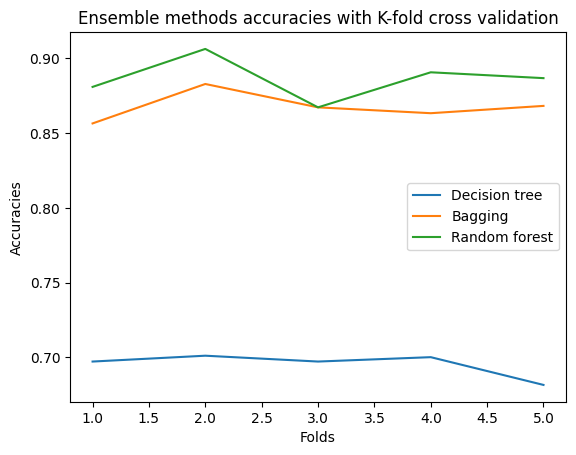

In [44]:
x = range(1, 6)

plt.plot(x, decision_tree_fold_accuracies, label = "Decision tree")
plt.plot(x, bagging_fold_accuracies, label = "Bagging")
plt.plot(x, random_forest_fold_accuracies, label = "Random forest")

plt.xlabel("Folds")
plt.ylabel("Accuracies")
plt.title("Ensemble methods accuracies with K-fold cross validation")
plt.legend()
plt.show()